In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

df = pd.read_csv('./steam.csv')
df.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


In [2]:
#A look at the data
df.describe()

,appid,english,required_age,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price
count,2.707500e+04,27075.000000,27075.000000,27075.000000,2.707500e+04,27075.000000,27075.000000,27075.00000,27075.000000
mean,5.962035e+05,0.981127,0.354903,45.248864,1.000559e+03,211.027147,149.804949,146.05603,6.078193
std,2.508942e+05,0.136081,2.406044,352.670281,1.898872e+04,4284.938531,1827.038141,2353.88008,7.874922
min,1.000000e+01,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000
25%,4.012300e+05,1.000000,0.000000,0.000000,6.000000e+00,2.000000,0.000000,0.00000,1.690000
50%,5.990700e+05,1.000000,0.000000,7.000000,2.400000e+01,9.000000,0.000000,0.00000,3.990000
75%,7.987600e+05,1.000000,0.000000,23.000000,1.260000e+02,42.000000,0.000000,0.00000,7.190000
max,1.069460e+06,1.000000,18.000000,9821.000000,2.644404e+06,487076.000000,190625.000000,190625.00000,421.990000


In [3]:
df.shape

(27075, 18)

In [4]:
#check for rows containing null values
null_rows = df.dropna(how='any', axis=0)
null_rows.shape

(27075, 18)

In [5]:
#check for columns containing null values
null_cols = df.dropna(how='any', axis=1)
null_cols.shape
#Looks like we have no null values!

(27075, 18)

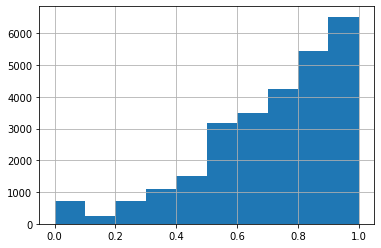

In [6]:
#Generates the field to predict: Positive Rating %
df['positive_rating_pct'] = df.positive_ratings / (df.positive_ratings + df.negative_ratings)
predictor_distribution = df['positive_rating_pct']
predictor_distribution.hist(bins=10)
#Looks like ratings are skewed heaviliy to the right. I guess people are more likely to leave reviews if they like the game?

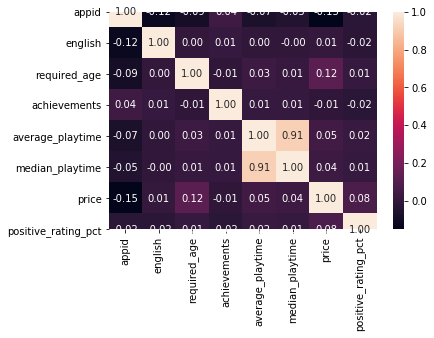

In [7]:
#Seperate out numeric variables
num_vars = df.select_dtypes(exclude=['object'])
#Drop these two, as they were used to generate the dependent variable
num_vars = num_vars.drop(['positive_ratings', 'negative_ratings'], axis=1)

#Check correlations
sns.heatmap(num_vars.corr(), annot=True, fmt=".2f");

#Mixed results here, hopefully the categorical variables will add some value

In [48]:
num_vars.columns

Index(['appid', 'english', 'required_age', 'achievements', 'average_playtime',
       'median_playtime', 'price', 'positive_rating_pct'],
      dtype='object')

In [15]:
#Analysis of the data
df_analysis = df.groupby('developer').filter(lambda x : len(x)>9)
df_analysis = df_analysis.loc[:, ['developer', 'positive_rating_pct']]
df_analysis = df_analysis.groupby('developer').agg('mean').sort_values('positive_rating_pct', ascending=True)

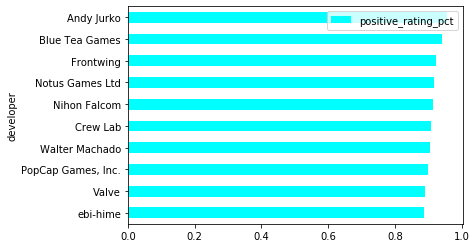

In [16]:
#Best rated developers with at least 10 published games
df_analysis.tail(10).plot(kind='barh', color=['cyan'])

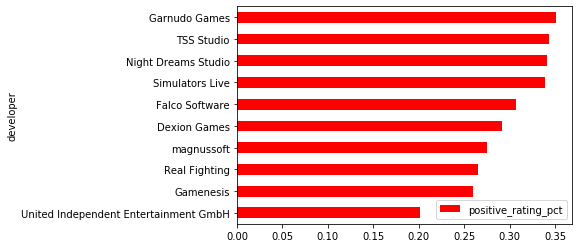

In [17]:
#Worst rated developers with at least 10 published games
df_analysis.head(10).plot(kind='barh', color=['red'])

In [44]:
#Price comparison data, we remove 0 values as Steam contains many free games which may skew the results
df_analysis = df.loc[:, ['price', 'positive_rating_pct']]
df_analysis = df_analysis.loc[df['price'] > 0]

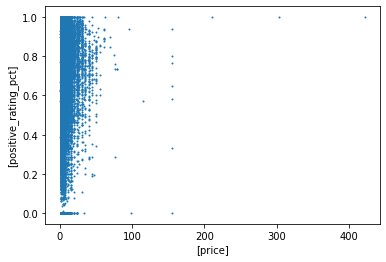

In [45]:
df_analysis.plot.scatter(x=['price'], y=['positive_rating_pct'], s=1)
#It seems we have some extreme outliers, lets remove those

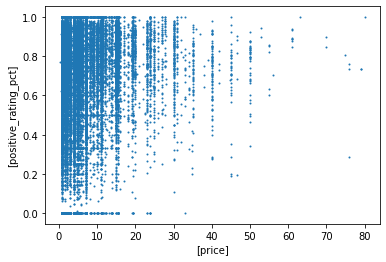

In [46]:
df_analysis = df_analysis.loc[df['price'] < 80]
df_analysis.plot.scatter(x=['price'], y=['positive_rating_pct'], s=1)

In [9]:
#Seperate out Categorical Variables
cat_vars = df.select_dtypes(include=['object'])
cat_vars.head()

num_of_values = {}
for x in cat_vars.columns:
    unique_values = cat_vars[x].nunique()
    num_of_values[x] = unique_values

#Here we can see how many distinct values each category has
print(num_of_values)
#We can ignore Name, as this is obviously not relevant. There numbers seem rather large. I don't think Steam really has
#3333 different categories. 

{'name': 27033, 'release_date': 2619, 'developer': 17113, 'publisher': 14354, 'platforms': 7, 'categories': 3333, 'genres': 1552, 'steamspy_tags': 6423, 'owners': 13}


In [10]:
#This shows us the actual unique values, because the values are concatenated with a ';'
num_of_values_actual = {}
for x in cat_vars.columns:
    unique_values = cat_vars[x].str.split(';').str[0].nunique()
    num_of_values_actual[x] = unique_values
    
print(num_of_values_actual)

#So? There are too many developers and publishers to realistically use them in this model, 
#but platforms, categories, genres and owners should be no problem.

{'name': 27030, 'release_date': 2619, 'developer': 16565, 'publisher': 14095, 'platforms': 3, 'categories': 23, 'genres': 26, 'steamspy_tags': 206, 'owners': 13}


In [11]:
#Time to create dummy columns for each of the values in platforms, categories, genres and owners
usable_cats = cat_vars[['platforms', 'categories', 'genres', 'owners']]
cat_values = {}
new_cats = cat_vars.copy()
for cat in ['platforms', 'categories', 'genres', 'owners']:
    column_values = usable_cats[cat].str.split(';').str[0].unique()
    for value in column_values:
        new_cats[cat+"_"+value] = np.where(usable_cats[cat].str.contains(value), 1, 0)

unique_values = list(cat_vars['owners'].str.split(';').str[0].unique())
for value in unique_values:
    new_cats["owners_"+value] = np.where(usable_cats['owners'] == value, 1, 0)

new_cats.head()
new_cats = new_cats.drop(['developer', 'publisher', 'platforms', 'categories', 'genres', 'steamspy_tags', 'owners'], axis=1)

#I'm aware this section is FAR from optimal, but it gets the job done, my Python still very unpolished.

In [12]:
#Join categorical and numeric tables together on index (safe to do since we did not sort the order at any point)
reg_def = new_cats.merge(num_vars, on=None, left_index=True, right_index=True)


reg_def = reg_def.drop(['name', 'release_date'], axis=1)

#Check all looks okay
reg_def.head()

,platforms_windows,platforms_mac,platforms_linux,categories_Multi-player,categories_Single-player,categories_Steam Workshop,categories_Partial Controller Support,categories_Online Multi-Player,categories_Steam Cloud,categories_Steam Leaderboards,...,owners_200000-500000,owners_0-20000,appid,english,required_age,achievements,average_playtime,median_playtime,price,positive_rating_pct
0,1,1,1,1,0,0,0,1,0,0,...,0,0,10,1,0,0,17612,317,7.19,0.973888
1,1,1,1,1,0,0,0,1,0,0,...,0,0,20,1,0,0,277,62,3.99,0.839787
2,1,1,1,1,0,0,0,0,0,0,...,0,0,30,1,0,0,187,34,3.99,0.895648
3,1,1,1,1,0,0,0,1,0,0,...,0,0,40,1,0,0,258,184,3.99,0.826623
4,1,1,1,1,1,0,0,0,0,0,...,0,0,50,1,0,0,624,415,3.99,0.947996


In [99]:
def steam_model(df, response_col, test_size=0.2, rand_state=5):
    
    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)
    
    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test

#Test your function with the above dataset
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = steam_model(reg_def, 'positive_rating_pct')
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))

The rsquared on the training data was 0.09378956314114162.  The rsquared on the test data was 0.10301397441149929.
